# Procesamiento de datos de gravedad

Importamos librerías que vamos a utilizar

In [1]:
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
import pygmt

import ensaio
import verde as vd
import boule as bl
import harmonica as hm

## Descargamos datos de gravedad

In [2]:
fname_gravity = ensaio.fetch_southern_africa_gravity(version=1)

In [3]:
raw_data = pd.read_csv(fname_gravity)
raw_data

longitude  latitude  height_sea_level_m  gravity_mgal
0       18.34444 -34.12971                32.2     979656.12
1       18.36028 -34.08833               592.5     979508.21
2       18.37418 -34.19583                18.4     979666.46
3       18.40388 -34.23972                25.0     979671.03
4       18.41112 -34.16444               228.7     979616.11
...          ...       ...                 ...           ...
14354   21.22500 -17.95833              1053.1     978182.09
14355   21.27500 -17.98333              1033.3     978183.09
14356   21.70833 -17.99166              1041.8     978182.69
14357   21.85000 -17.95833              1033.3     978193.18
14358   21.98333 -17.94166              1022.6     978211.38

[14359 rows x 4 columns]

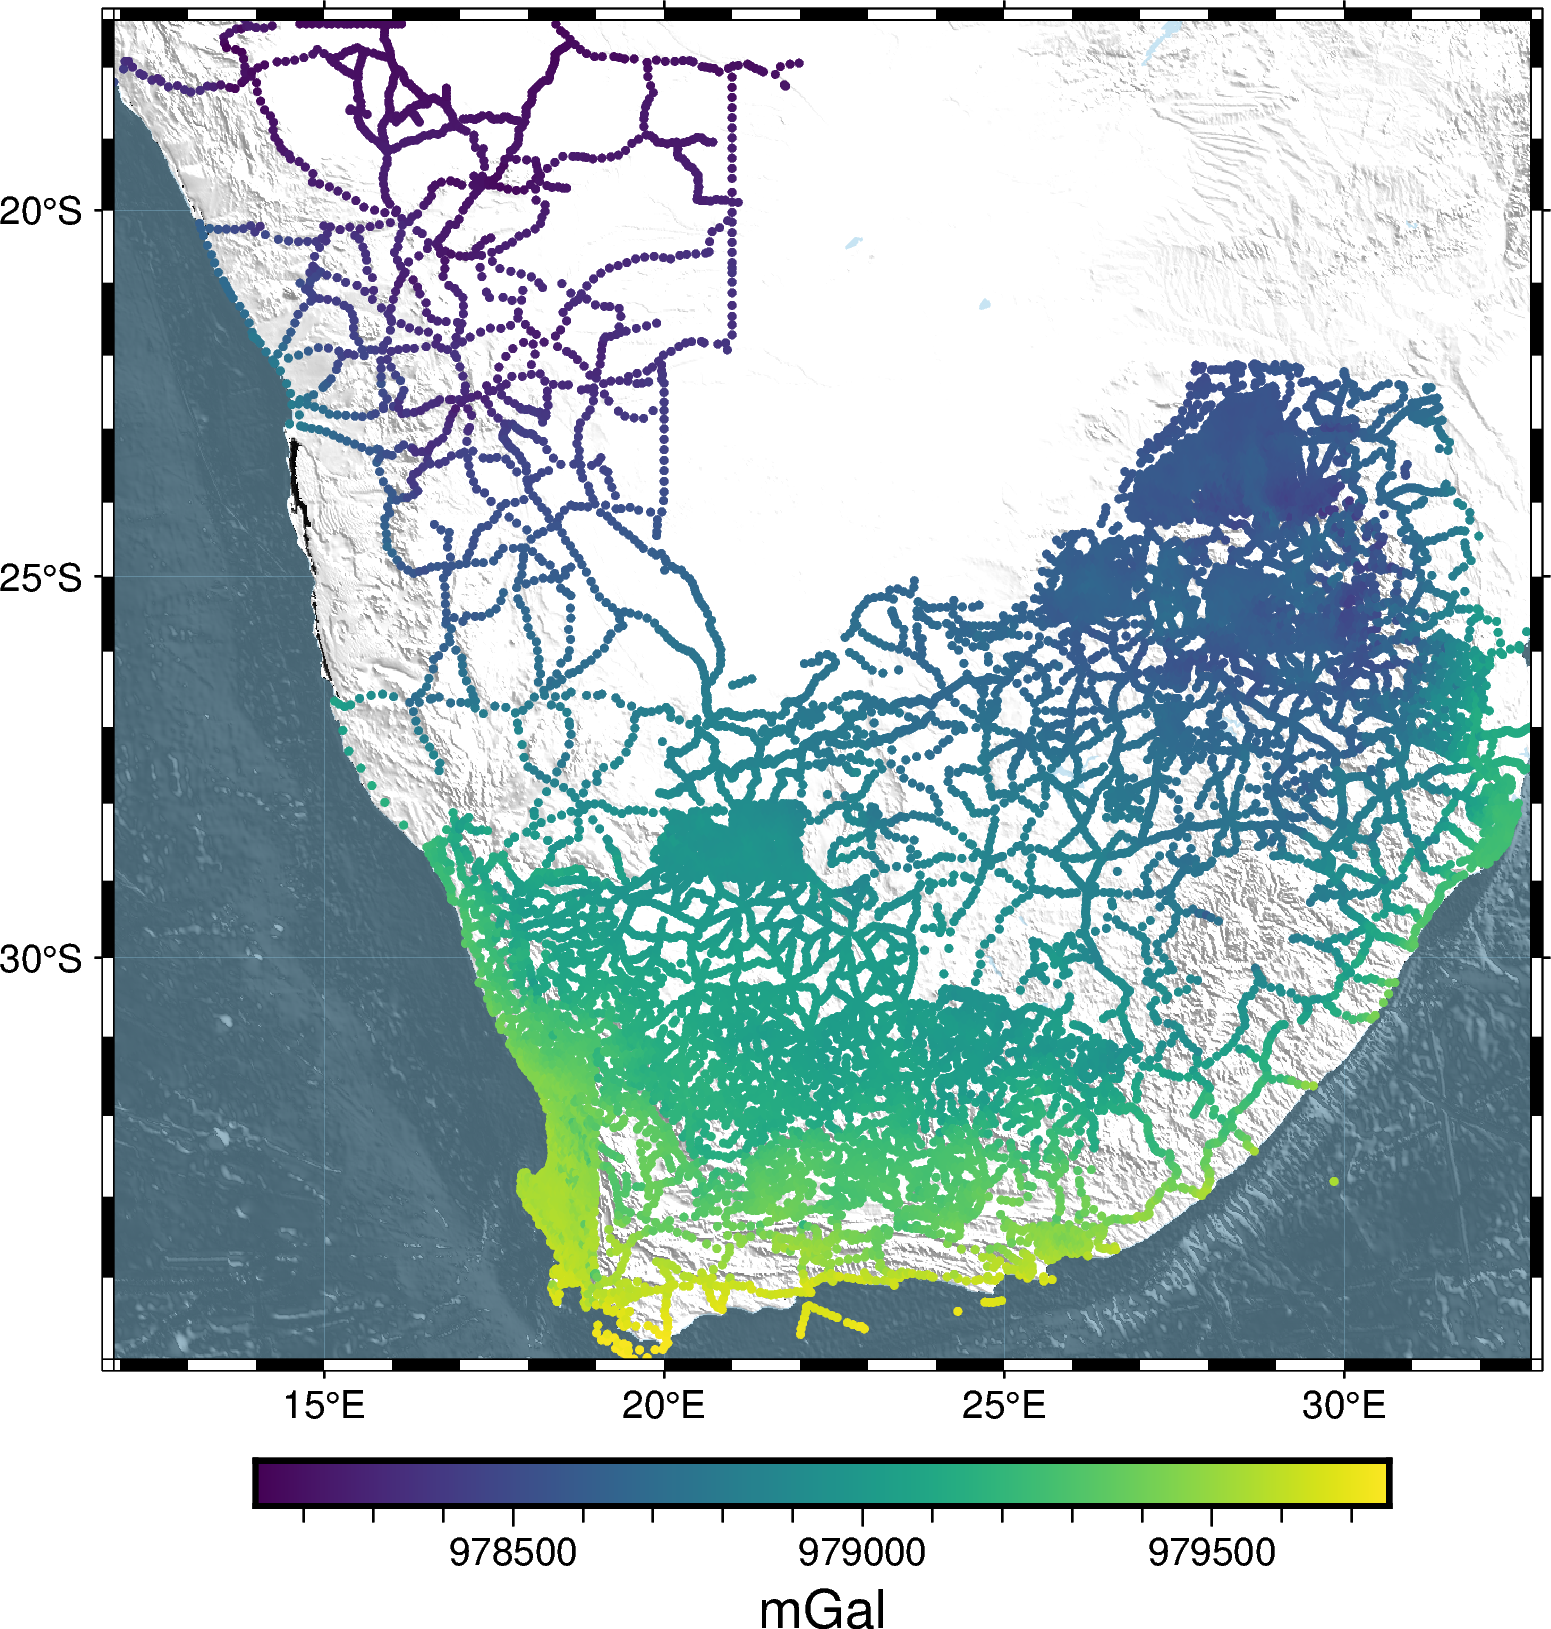

In [4]:
fig = pygmt.Figure()
gmt_projection = "M12c"

raw_region = vd.get_region((raw_data.longitude, raw_data.latitude))

pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_01m",
    region=raw_region,
    projection=gmt_projection,
    shading="+a45+nt0.7",
    cmap=True,
)
fig.coast(
    water="#8fcae7",
    transparency=50,
)
pygmt.makecpt(
    cmap="viridis",
    series=[raw_data.gravity_mgal.min(), raw_data.gravity_mgal.max()],
)
fig.plot(
    x=raw_data.longitude,
    y=raw_data.latitude,
    fill=raw_data.gravity_mgal,
    cmap=True,
    style="c2p",
    projection=gmt_projection,
    frame="af",
)
fig.colorbar(frame='af+l"mGal"')
fig.show()

## Recortamos los datos al complejo igneo de Bushveld

In [5]:
region = (25, 32, -27, -23)

In [6]:
inside = vd.inside((raw_data.longitude, raw_data.latitude), region)
data = raw_data[inside]

In [7]:
def plot_scatter(longitude, latitude, values, center=False, cmap="viridis", label=None):
    """Plot scatter points using PyGMT"""
    fig = pygmt.Figure()
    gmt_projection = "M12c"
    region = vd.get_region((longitude, latitude))
    
    pygmt.makecpt(cmap="gray")
    fig.grdimage(
        "@earth_relief_01m",
        region=region,
        projection=gmt_projection,
        shading="+a45+nt0.7",
        cmap=True,
    )
    if center:
        maxabs = vd.maxabs(values)
        series = [-maxabs, maxabs] 
    else:
        series=[np.nanmin(values), np.nanmax(values)]
        
    pygmt.makecpt(cmap=cmap, series=series)
    fig.plot(
        x=longitude,
        y=latitude,
        fill=values,
        cmap=True,
        style="c3p",
        projection=gmt_projection,
        frame="af",
    )
    frame = "af"
    if label is not None:
        frame += f'+l"{label}"'
    fig.colorbar(frame=frame)
    fig.show()

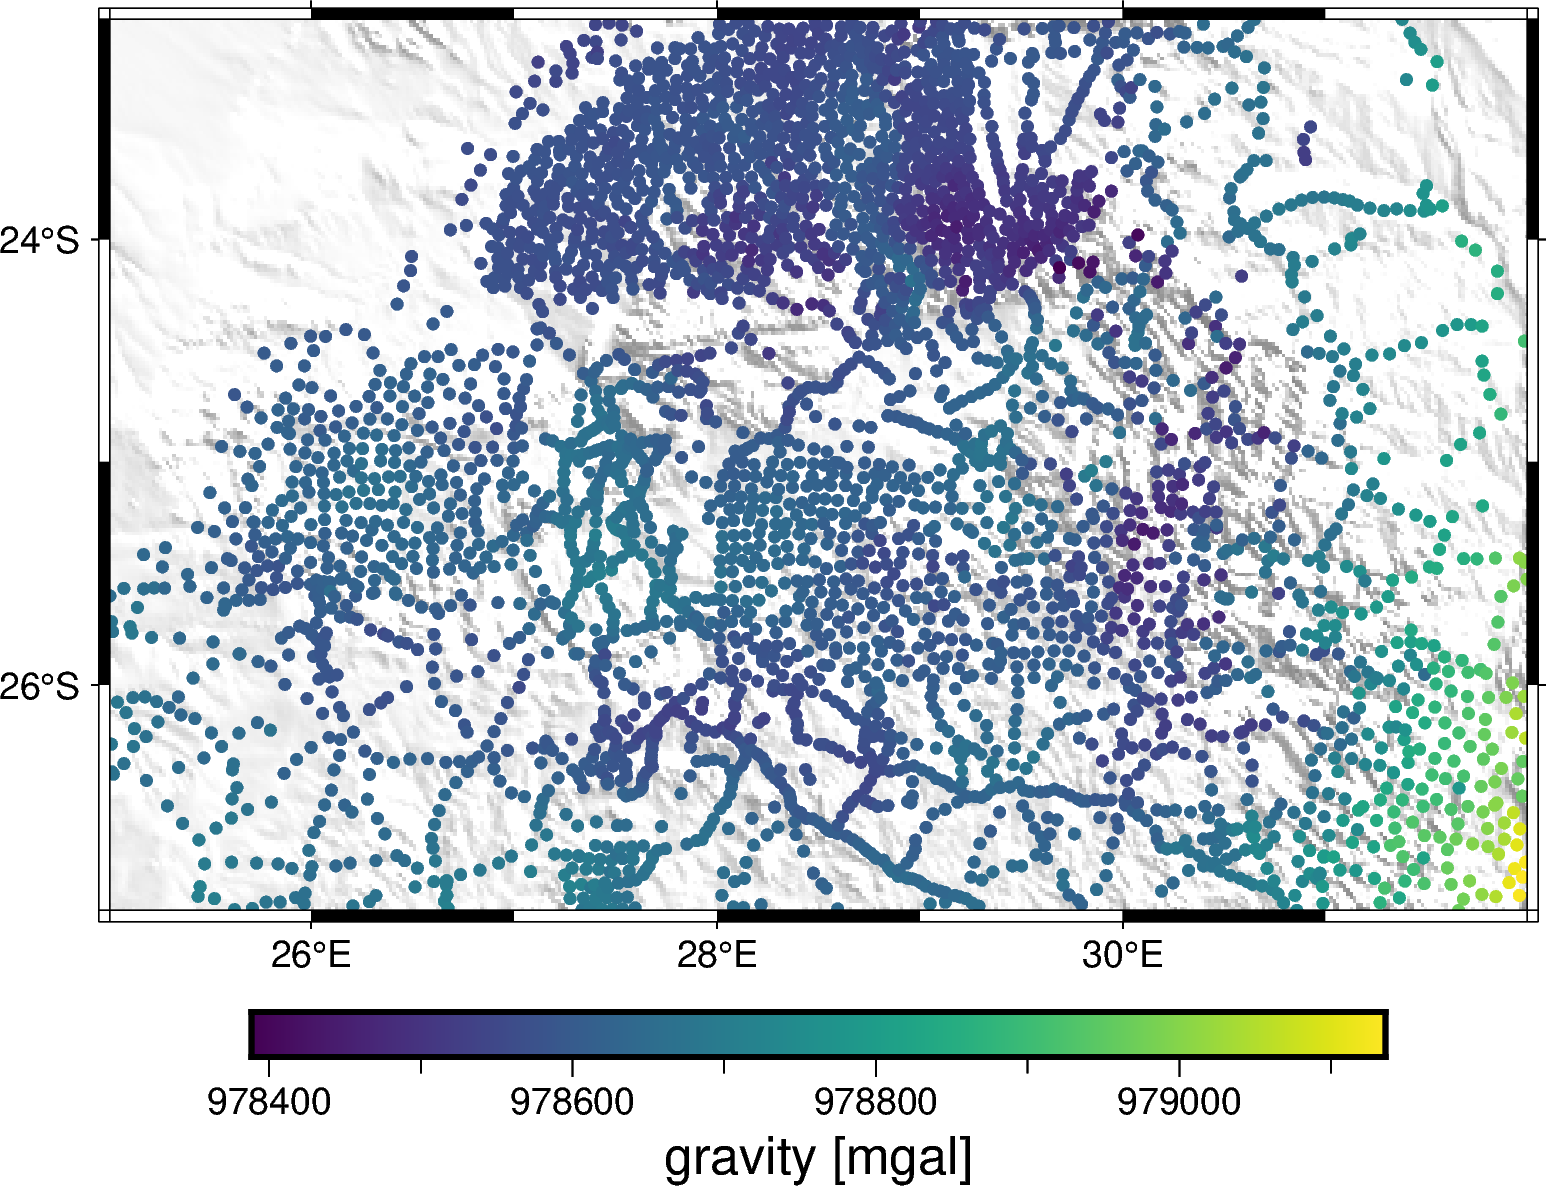

In [8]:
plot_scatter(data.longitude, data.latitude, data.gravity_mgal, label="gravity [mgal]")

## Gravity disturbance (disturbio de gravedad)

In [9]:
ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height_sea_level_m)

In [10]:
disturbance = data.gravity_mgal - normal_gravity
data = data.assign(disturbance=disturbance)
data

longitude  latitude  height_sea_level_m  gravity_mgal  disturbance
8648    25.01500 -26.26334              1230.2     978681.38    16.667039
8649    25.01932 -26.38713              1297.0     978669.02    16.031458
8650    25.02499 -26.39667              1304.8     978669.28    18.011910
8651    25.04500 -26.07668              1165.2     978681.08     9.653319
8652    25.07668 -26.35001              1262.5     978665.19     4.225041
...          ...       ...                 ...           ...          ...
12974   31.51500 -23.86333               300.5     978776.85    -8.552819
12975   31.52499 -23.30000               280.7     978798.55    44.312860
12976   31.54832 -23.19333               245.7     978803.55    45.490800
12977   31.57333 -23.84833               226.8     978808.44     1.289634
13557   31.37500 -23.00000               285.6     978734.77     1.616946

[3877 rows x 5 columns]

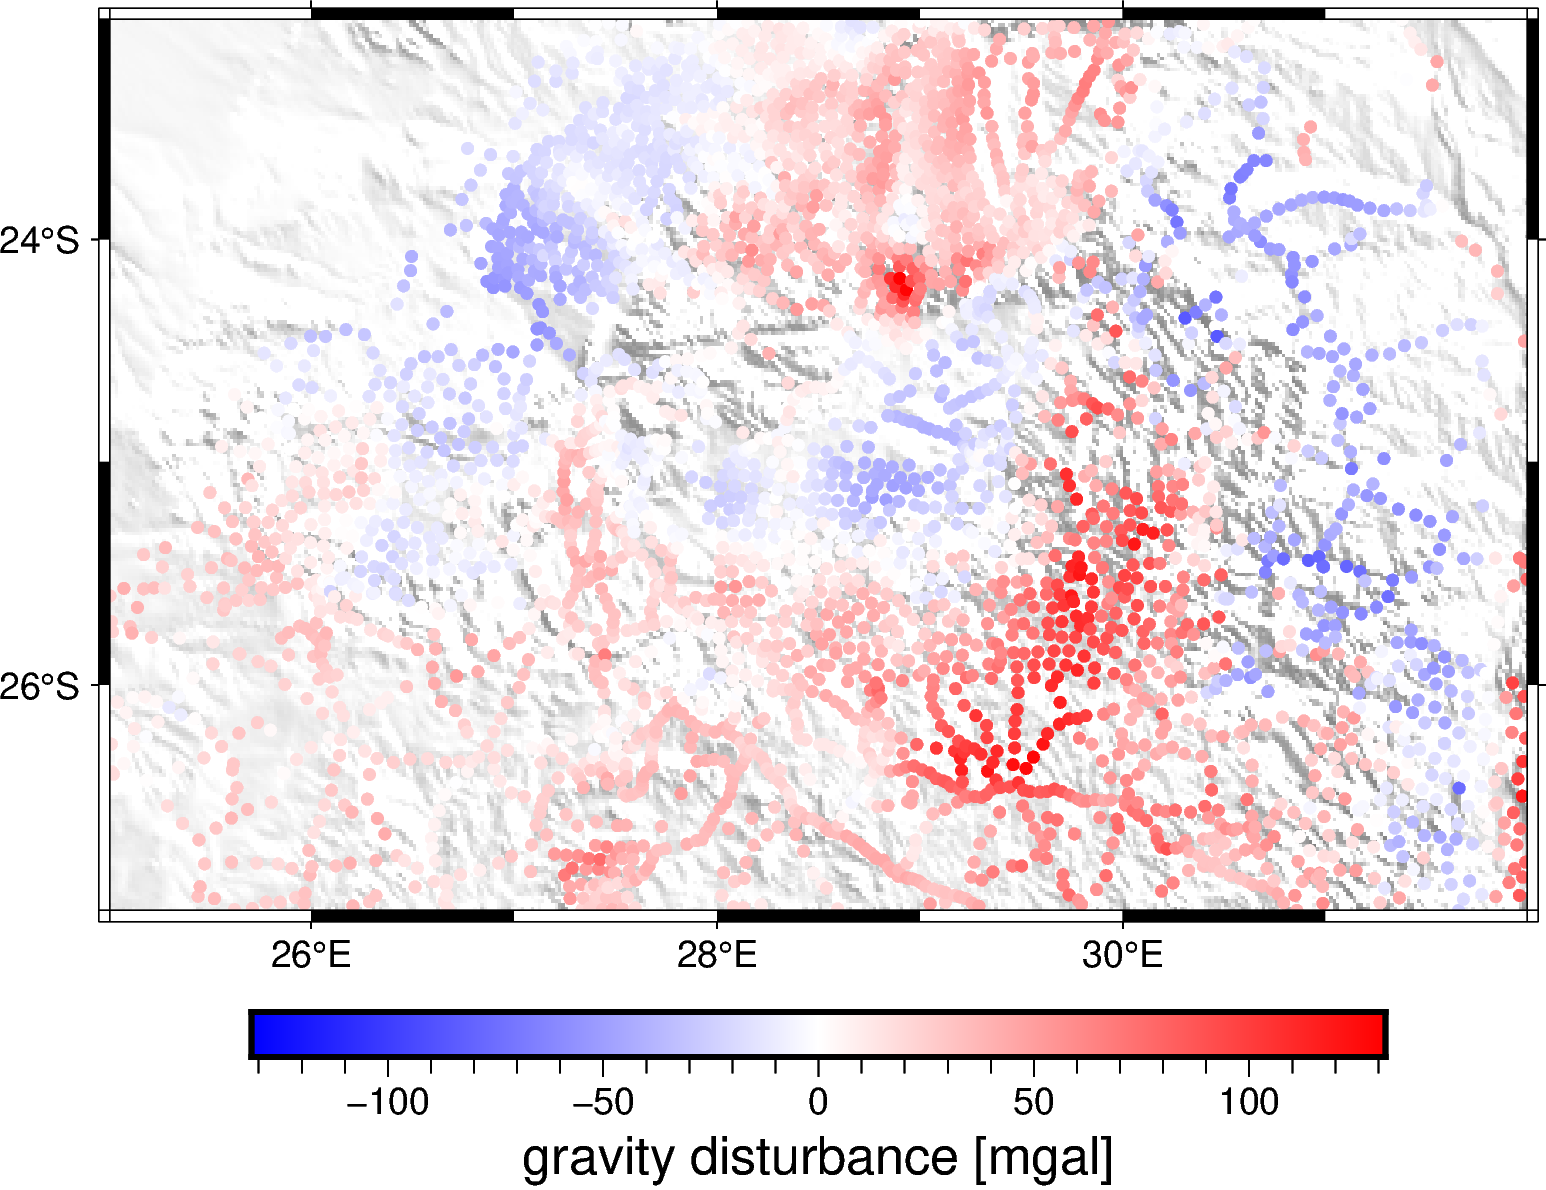

In [11]:
plot_scatter(
    data.longitude,
    data.latitude,
    data.disturbance,
    cmap="polar",
    center=True,
    label="gravity disturbance [mgal]"
)

## Efecto topografico

Descargamos una grilla de topografia

In [12]:
topo_fname = ensaio.fetch_earth_topography(version=1)

In [13]:
topography = xr.load_dataarray(topo_fname)
topography

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

La recortamos alrededor de la zona de estudio

In [14]:
region_pad = vd.pad_region(region, pad=2)
topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography

<xarray.DataArray 'topography' (latitude: 49, longitude: 67)>
array([[ 1288.,  1272.,  1252., ..., -2270., -2194., -2123.],
       [ 1265.,  1348.,  1400., ..., -2098., -1916., -1810.],
       [ 1235.,  1367.,  1464., ..., -1913., -1757., -1710.],
       ...,
       [ 1010.,  1003.,   999., ...,   101.,    93.,    93.],
       [ 1011.,  1003.,   999., ...,   116.,    89.,    84.],
       [ 1015.,  1007.,  1002., ...,   157.,   104.,    82.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 23.0 23.17 23.33 23.5 ... 33.67 33.83 34.0
  * latitude   (latitude) float64 -29.0 -28.83 -28.67 ... -21.33 -21.17 -21.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

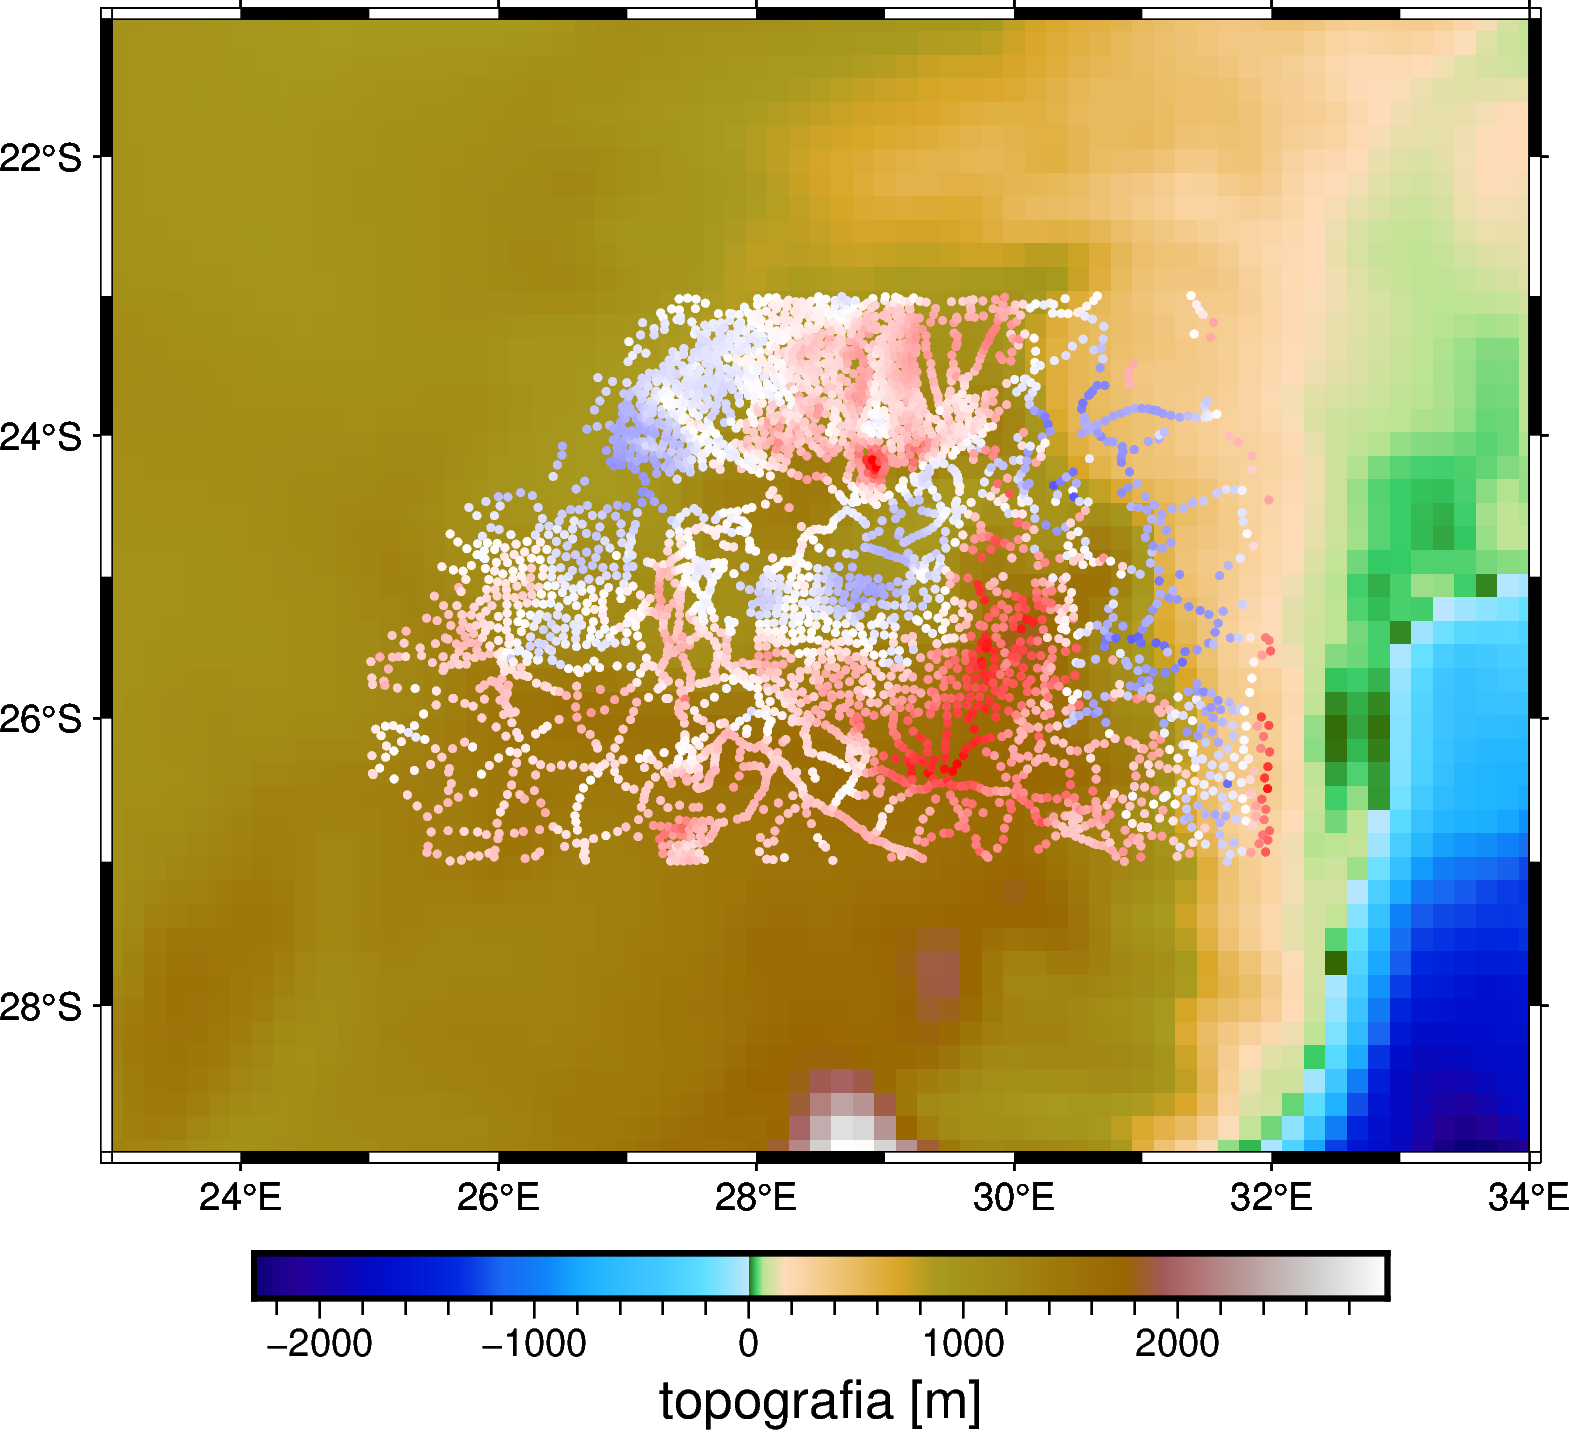

In [15]:
fig = pygmt.Figure()
gmt_projection = "M12c"
fig.grdimage(topography, projection=gmt_projection, cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topografia [m]"')

maxabs = vd.maxabs(data.disturbance)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.disturbance,
    cmap=True,
    style="c2p",
    projection=gmt_projection,
    frame="af",
)
# fig.colorbar(frame='af+l"mGal"')
fig.show()

Proyectamos la grilla a coordenadas planas

In [16]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [17]:
topo_proj = vd.project_grid(topography, projection)
topo_proj

/home/santi/.mambaforge/envs/2023-fatiando-igeba/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.DataArray 'topography' (northing: 49, easting: 67)>
array([[           nan,  1270.66666667,  1252.        , ...,
        -2257.        , -2194.        , -2123.        ],
       [           nan,  1336.78139188,  1395.05582383, ...,
        -2103.31164872, -1925.28703361, -1820.45626446],
       [           nan,  1351.15399228,  1459.82065894, ...,
        -1925.08090774, -1767.38305044, -1716.5302204 ],
       ...,
       [           nan,  1004.18257541,   998.93914153, ...,
          102.52146175,    95.13004645,    95.19090492],
       [           nan,  1005.28222388,   999.96933433, ...,
          128.03365742,    95.2617801 ,    86.53777113],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * easting   (easting) float64 2.323e+06 2.339e+06 ... 3.417e+06 3.433e+06
  * northing  (northing) float64 -3.043e+06 -3.025e+06 ... -2.174e+06 -2.156e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

Creamos un modelo de topografia con prismas rectangulares

In [18]:
density = np.where(topo_proj < 0, 1040 - 2670, 2670)
 
prisms = hm.prism_layer(
    (topo_proj.easting, topo_proj.northing),
    reference=0,
    surface=topo_proj,
    properties={"density": density},
)
prisms

<xarray.Dataset>
Dimensions:   (northing: 49, easting: 67)
Coordinates:
  * easting   (easting) float64 2.323e+06 2.339e+06 ... 3.417e+06 3.433e+06
  * northing  (northing) float64 -3.043e+06 -3.025e+06 ... -2.174e+06 -2.156e+06
    top       (northing, easting) float64 nan 1.271e+03 1.252e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int64 2670 2670 2670 2670 ... 2670 2670 2670
Attributes:
    coords_units:      meters
    properties_units:  SI

Calculamos el efecto topografico en cada punto de observación

In [19]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data = data.assign(easting=easting, northing=northing)
data

longitude  latitude  height_sea_level_m  gravity_mgal  disturbance   
8648    25.01500 -26.26334              1230.2     978681.38    16.667039  \
8649    25.01932 -26.38713              1297.0     978669.02    16.031458   
8650    25.02499 -26.39667              1304.8     978669.28    18.011910   
8651    25.04500 -26.07668              1165.2     978681.08     9.653319   
8652    25.07668 -26.35001              1262.5     978665.19     4.225041   
...          ...       ...                 ...           ...          ...   
12974   31.51500 -23.86333               300.5     978776.85    -8.552819   
12975   31.52499 -23.30000               280.7     978798.55    44.312860   
12976   31.54832 -23.19333               245.7     978803.55    45.490800   
12977   31.57333 -23.84833               226.8     978808.44     1.289634   
13557   31.37500 -23.00000               285.6     978734.77     1.616946   

            easting      northing  
8648   2.526066e+06 -2.733052e+06  
8649   2.526503e+06 -2.746924e+06  
8650   2.527075e+06 -2.747994e+06  
8651   2.529096e+06 -2.712163e+06  
8652   2.532295e+06 -2.742763e+06  
...             ...           ...  
12974  3.182450e+06 -2.466945e+06  
12975  3.183459e+06 -2.405224e+06  
12976  3.185814e+06 -2.393567e+06  
12977  3.188340e+06 -2.465298e+06  
13557  3.168312e+06 -2.372463e+06  

[3877 rows x 7 columns]

In [20]:
coordinates = (data.easting, data.northing, data.height_sea_level_m)
topo_effect = prisms.prism_layer.gravity(coordinates, field="g_z")

bouguer = data.disturbance - topo_effect
data = data.assign(bouguer=bouguer)
data

longitude  latitude  height_sea_level_m  gravity_mgal  disturbance   
8648    25.01500 -26.26334              1230.2     978681.38    16.667039  \
8649    25.01932 -26.38713              1297.0     978669.02    16.031458   
8650    25.02499 -26.39667              1304.8     978669.28    18.011910   
8651    25.04500 -26.07668              1165.2     978681.08     9.653319   
8652    25.07668 -26.35001              1262.5     978665.19     4.225041   
...          ...       ...                 ...           ...          ...   
12974   31.51500 -23.86333               300.5     978776.85    -8.552819   
12975   31.52499 -23.30000               280.7     978798.55    44.312860   
12976   31.54832 -23.19333               245.7     978803.55    45.490800   
12977   31.57333 -23.84833               226.8     978808.44     1.289634   
13557   31.37500 -23.00000               285.6     978734.77     1.616946   

            easting      northing     bouguer  
8648   2.526066e+06 -2.733052e+06 -120.666487  
8649   2.526503e+06 -2.746924e+06 -127.901763  
8650   2.527075e+06 -2.747994e+06 -125.919331  
8651   2.529096e+06 -2.712163e+06 -117.200204  
8652   2.532295e+06 -2.742763e+06 -133.919121  
...             ...           ...         ...  
12974  3.182450e+06 -2.466945e+06  -41.769501  
12975  3.183459e+06 -2.405224e+06   17.361124  
12976  3.185814e+06 -2.393567e+06   26.274278  
12977  3.188340e+06 -2.465298e+06  -15.462695  
13557  3.168312e+06 -2.372463e+06  -24.668039  

[3877 rows x 8 columns]

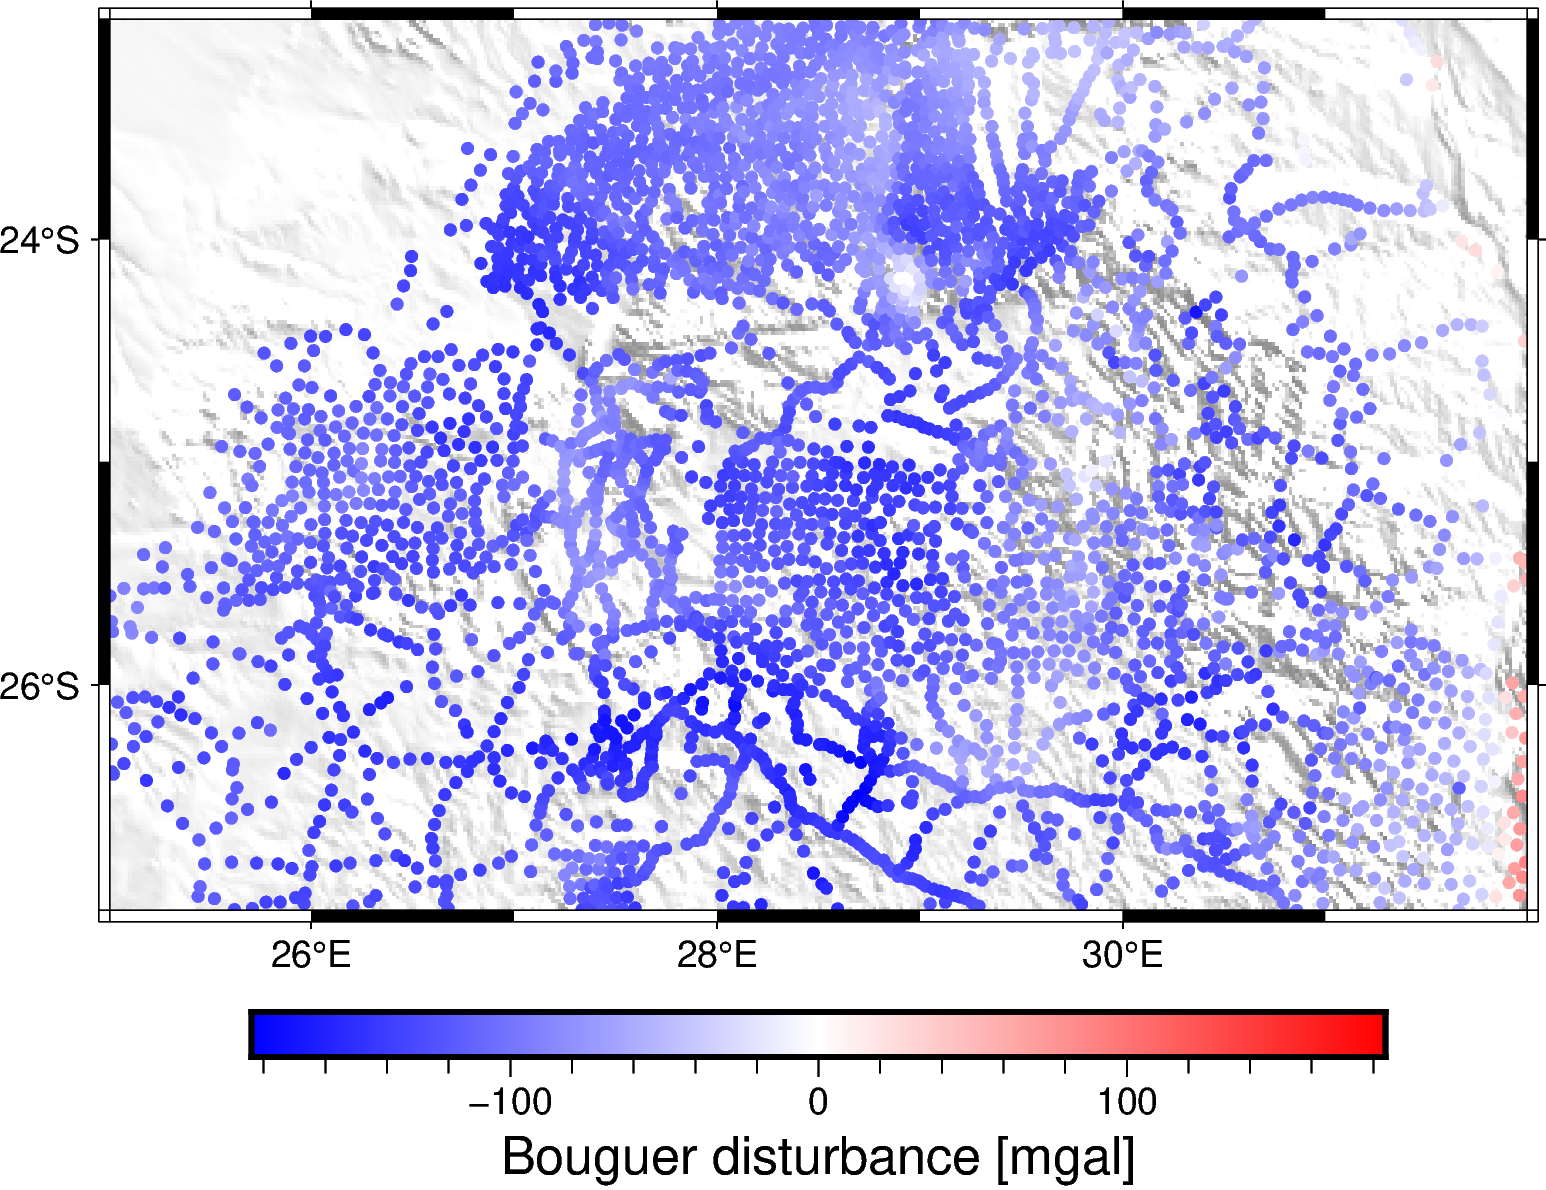

In [21]:
plot_scatter(
    data.longitude,
    data.latitude,
    data.bouguer,
    cmap="polar",
    center=True,
    label="Bouguer disturbance [mgal]",
)

## Calcular la gravedad residual

Usamos fuentes equivalentes profundas para calcular el campo regional de gravedad.

In [22]:
deep_sources = hm.EquivalentSources(depth=500e3, damping=1000)
deep_sources.fit(coordinates, data.bouguer)

regional = deep_sources.predict(coordinates)

Calculamos residual como la diferencia entre Bouguer y la regional.

In [23]:
residual = data.bouguer - regional

In [24]:
data = data.assign(residual=residual)
data

longitude  latitude  height_sea_level_m  gravity_mgal  disturbance   
8648    25.01500 -26.26334              1230.2     978681.38    16.667039  \
8649    25.01932 -26.38713              1297.0     978669.02    16.031458   
8650    25.02499 -26.39667              1304.8     978669.28    18.011910   
8651    25.04500 -26.07668              1165.2     978681.08     9.653319   
8652    25.07668 -26.35001              1262.5     978665.19     4.225041   
...          ...       ...                 ...           ...          ...   
12974   31.51500 -23.86333               300.5     978776.85    -8.552819   
12975   31.52499 -23.30000               280.7     978798.55    44.312860   
12976   31.54832 -23.19333               245.7     978803.55    45.490800   
12977   31.57333 -23.84833               226.8     978808.44     1.289634   
13557   31.37500 -23.00000               285.6     978734.77     1.616946   

            easting      northing     bouguer   residual  
8648   2.526066e+06 -2.733052e+06 -120.666487   1.220507  
8649   2.526503e+06 -2.746924e+06 -127.901763  -5.960900  
8650   2.527075e+06 -2.747994e+06 -125.919331  -3.950969  
8651   2.529096e+06 -2.712163e+06 -117.200204   4.711365  
8652   2.532295e+06 -2.742763e+06 -133.919121 -11.729306  
...             ...           ...         ...        ...  
12974  3.182450e+06 -2.466945e+06  -41.769501  17.404382  
12975  3.183459e+06 -2.405224e+06   17.361124  69.688664  
12976  3.185814e+06 -2.393567e+06   26.274278  76.898935  
12977  3.188340e+06 -2.465298e+06  -15.462695  42.298680  
13557  3.168312e+06 -2.372463e+06  -24.668039  26.164371  

[3877 rows x 9 columns]

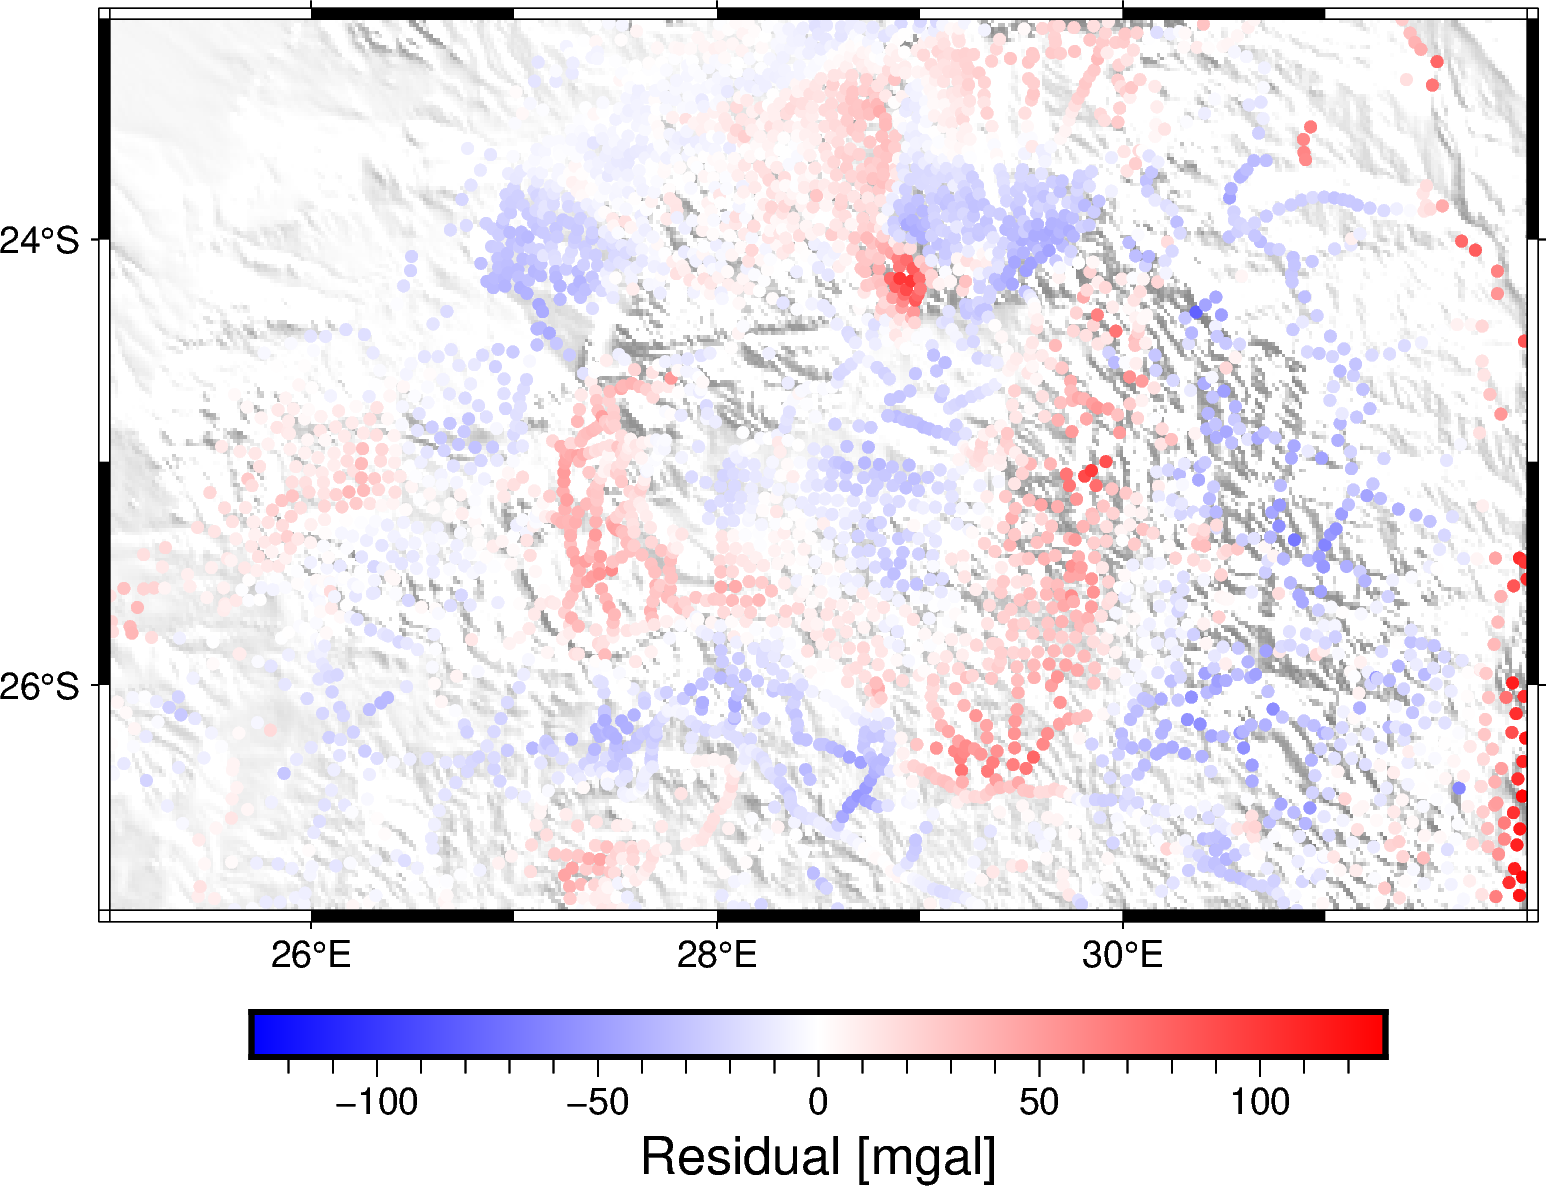

In [25]:
plot_scatter(
    data.longitude,
    data.latitude,
    data.residual,
    cmap="polar",
    center=True,
    label="Residual [mgal]",
)

## Grillado con fuentes equivalentes

Definimos fuentes equivalentes someras para grillar la gravedad residual

In [26]:
eq_sources = hm.EquivalentSources(depth=10e3, damping=10)
eq_sources.fit(coordinates, data.residual)

EquivalentSources(damping=10, depth=10000.0)

In [27]:
grid_coords = vd.grid_coordinates(region=region, spacing=0.01, extra_coords=2200)
grid = eq_sources.grid(
    coordinates=grid_coords,
    projection=projection,
    dims=("latitude", "longitude"),
    data_names="residual_gravity",
)
grid

<xarray.Dataset>
Dimensions:           (latitude: 401, longitude: 701)
Coordinates:
  * longitude         (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude          (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward            (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    residual_gravity  (latitude, longitude) float64 0.6061 0.6375 ... 19.62
Attributes:
    metadata:  Generated by EquivalentSources(damping=10, depth=10000.0)

In [29]:
grid = vd.convexhull_mask(
    (data.longitude, data.latitude), grid=grid
)
grid

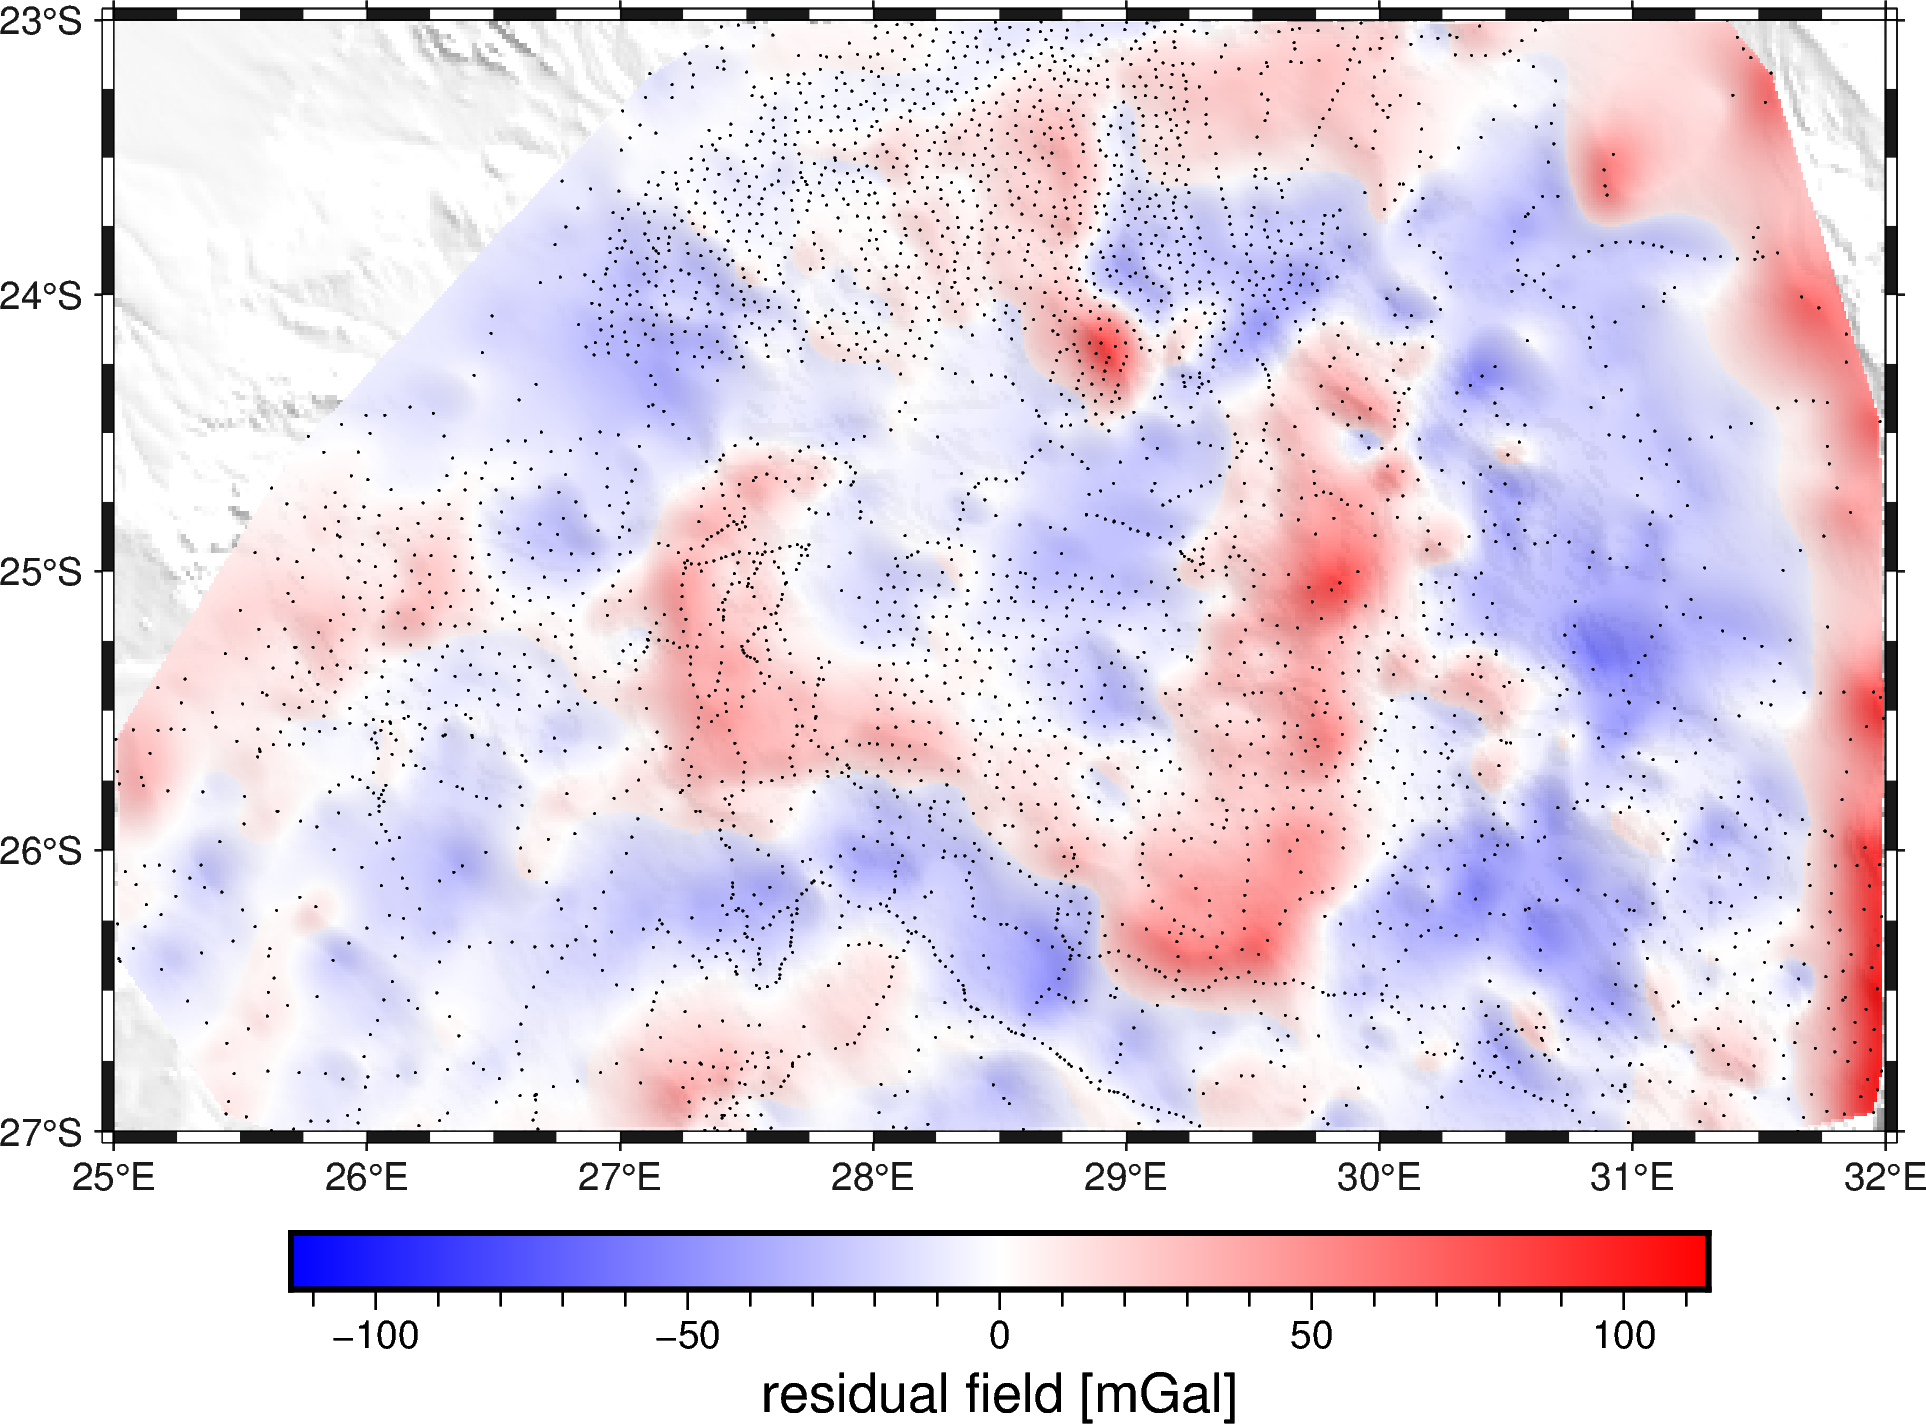

In [30]:
fig = pygmt.Figure()
gmt_projection = "M15c"

pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_01m",
    region=region,
    projection=gmt_projection,
    shading="+a45+nt0.7",
    cmap=True,
)

maxabs = vd.maxabs(grid.residual_gravity)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs], no_bg=True)
fig.grdimage(
    grid.residual_gravity,
    shading="+a45+nt0.15",
    projection=gmt_projection,
    frame=True,
    nan_transparent=True,
    transparency=10,
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.02c",
    fill="black",
)
fig.show()